In [1]:
import os
os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [3]:
import json

In [5]:
import ast

import ast_scope
import pandas as pd
import requests
import tqdm.auto as tqdm
import neurosym as ns
import matplotlib.pyplot as plt

from imperative_stitch.compress.julia_stitch import run_julia_stitch
from imperative_stitch.compress.abstraction import Abstraction
from imperative_stitch.compress.manipulate_abstraction import (
    abstraction_calls_to_bodies,
    abstraction_calls_to_bodies_recursively,
    abstraction_calls_to_stubs,
    collect_abstraction_calls,
    replace_abstraction_calls,
)
from imperative_stitch.data.github_repository_downloader import (
    single_repo_random_subset_of_size,
    one_each,
    multiple_repos_random_subset_of_size,
)

In [9]:
from imperative_stitch.utils.remove_docstrings import remove_docstrings
from imperative_stitch.experiments.compression_hyperparameter_search.datasets import (
    datasets,
    sizes,
    datasets_for_size,
)
from imperative_stitch.experiments.compression_hyperparameter_search.hyperparameters import (
    sample_hyperparameters,
)
from imperative_stitch.experiments.compression_hyperparameter_search.run_stitch import (
    run_stitch_with_hyperparameters,
)
from imperative_stitch.experiments.compression_hyperparameter_search.run_experiment import (
    run_experiment_up_to_seed,
    vary_min_num_matches,
)
from imperative_stitch.experiments.compression_hyperparameter_search.analysis import *

In [7]:
d = datasets()

In [10]:
rs = run_experiment_up_to_seed(*vary_min_num_matches(), skip_missing=True)

  0%|          | 0/90 [00:00<?, ?it/s]

Skipping ('ml_repo', 1000000) with seed 0
Skipping ('ml_repo', 1000000) with seed 2


In [35]:
results = pd.DataFrame(
    {
        i: {
            **vary_min_num_matches()[1](i),
            **{("wall_time", *k): wall_time(v) for k, v in r.items()},
            **{("compression", *k): s_exp_compression(v) for k, v in r.items()},
        }
        for i, r in enumerate(rs)
    }
).T
results_no_infcol = results[
    [
        x
        for x in results
        if not isinstance(x, tuple) or np.isfinite(list(results[x])).all()
    ]
]

In [61]:
def geomean(x):
    return np.exp(np.log(x).mean())

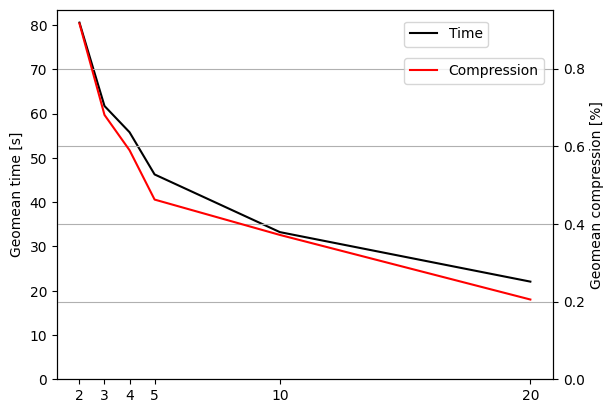

In [93]:
ax_1 = plt.gca()
ax_2 = ax_1.twinx()
a = ax_1.plot(
    results_no_infcol.minimum_number_matches,
    geomean(results_no_infcol[[x for x in results_no_infcol if x[0] == "wall_time"]].T),
    color="black",
    label="Time",
)
b = ax_2.plot(
    results_no_infcol.minimum_number_matches,
    (
        geomean(
            results_no_infcol[[x for x in results_no_infcol if x[0] == "compression"]].T
        )
        - 1
    )
    * 100,
    color="red",
    label="Compression",
)
plt.xticks(sorted(set(results_no_infcol.minimum_number_matches)))
plt.xlabel("Minimum number matches")
ax_1.set_ylabel("Geomean time [s]")
ax_2.set_ylabel("Geomean compression [%]")
ax_1.set_ylim(0, ax_1.get_ylim()[1])
ax_2.set_ylim(0, ax_2.get_ylim()[1])
plt.grid()
ax_1.legend(loc=(0.7, 0.9))
ax_2.legend(loc=(0.7, 0.8))
plt.show()